# Azure OpenAI OCR Sample
Use Azure OpenAI (vision) to extract text and a few key fields from images in `../docs`.


## Prerequisites
- Python 3.9+ with `openai>=1.42.0` installed.
- Azure OpenAI resource with a vision-capable model deployment (e.g., GPT-4o or GPT-5).
- Environment variables: `AZURE_OPENAI_ENDPOINT`, `AZURE_OPENAI_KEY`, `AZURE_OPENAI_DEPLOYMENT` (deployment name), optional `AZURE_OPENAI_API_VERSION`.
- (Optional) `python-dotenv` to load a local `.env`.


In [19]:
import base64
import json
import mimetypes
import os
from pathlib import Path

try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT", "https://<your-endpoint>.openai.azure.com")
AZURE_OPENAI_KEY = os.getenv("AZURE_API_KEY", "")
AZURE_OPENAI_DEPLOYMENT = os.getenv("AZURE_OPENAI_DEPLOYMENT", "gpt-4o")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION", "2024-10-01-preview")

if not AZURE_OPENAI_KEY:
    raise ValueError("Set AZURE_OPENAI_KEY (and endpoint/deployment) before running.")

if AZURE_OPENAI_ENDPOINT.startswith("https://<your-endpoint>"):
    raise ValueError("Set AZURE_OPENAI_ENDPOINT to your Azure OpenAI endpoint.")


In [20]:
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_KEY,
    api_version=AZURE_OPENAI_API_VERSION,
)
print(f"Using deployment '{AZURE_OPENAI_DEPLOYMENT}' at {AZURE_OPENAI_ENDPOINT}")


Using deployment 'gpt-4o' at https://eval-foundry.cognitiveservices.azure.com/openai/deployments/gpt-5/chat/completions?api-version=2024-05-01-preview


In [21]:
# Choose a sample file from ../docs
sample_file_path = Path("../docs/cl_23032-12.pdf_14.png")

if not sample_file_path.exists():
    raise FileNotFoundError("Update sample_file_path to point to an existing image.")

mime_type, _ = mimetypes.guess_type(sample_file_path.name)
if mime_type is None:
    mime_type = "image/png"

with sample_file_path.open("rb") as document_file:
    base64_payload = base64.b64encode(document_file.read()).decode("utf-8")

def encode_image_data_url(payload: str, mime_type: str) -> str:
    return f"data:{mime_type};base64,{payload}"

document_data_url = encode_image_data_url(base64_payload, mime_type)
print(f"Prepared {sample_file_path.name} as {mime_type} (base64 length: {len(base64_payload)} chars)")


Prepared cl_23032-12.pdf_14.png as image/png (base64 length: 479356 chars)


In [22]:
# Request OCR with key fields
fields_to_extract = ["DocumentType", "PrimaryName", "Date"]

prompt = (
    "Extract text from the document image and return JSON with two keys: "
    "'markdown' (a markdown transcription preserving structure) and 'key_fields' "
    f"(object with keys: {fields_to_extract}; use null if unknown)."
)

response = client.chat.completions.create(
    model=AZURE_OPENAI_DEPLOYMENT,
    response_format={"type": "json_object"},
    messages=[
        {"role": "system", "content": "You perform OCR and return markdown plus key fields. Extract following in JSON format, Name, SSN, # of Dependants."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": document_data_url}},
            ],
        },
    ],
)

och_result = json.loads(response.choices[0].message.content)
print("Top-level keys:", list(och_result.keys()))


Top-level keys: ['markdown', 'key_fields']


In [23]:
from pprint import pprint

markdown_text = och_result.get("markdown", "")
key_fields = och_result.get("key_fields", {})

print("Key fields:")
pprint(key_fields)

print("Markdown preview (first 20 lines):")
for line in markdown_text.splitlines()[:20]:
    print(line)


Key fields:
{'# of Dependants': 1, 'Name': 'Heather A Johnson', 'SSN': None}
Markdown preview (first 20 lines):
# NATIONWIDE LIFE AND ANNUITY INSURANCE COMPANY
Application for Individual Life Insurance
P.O. Box 182835, Columbus, Ohio 43218-2835
Fax: 1-888-677-7393 • www.nationwide.com

## PART A — CLIENT INFORMATION

### 1. Proposed Primary Insured
- Name (First, MI, Last): Heather A Johnson
- Address: 123 Miracle Rd
- City: Des Moines
- State & Zip Code: IA [zip illegible]
- County: Dallas
- Sex: F
- Former Name: —
- Marital Status: [illegible]
- Age: 21
- Date of Birth (mm/dd/yyyy): 08-01-2009
- State of Birth: IA
- E-Mail Address: [illegible]


C:\Users\jacwang\AppData\Local\Temp\ipykernel_24520\4130407704.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


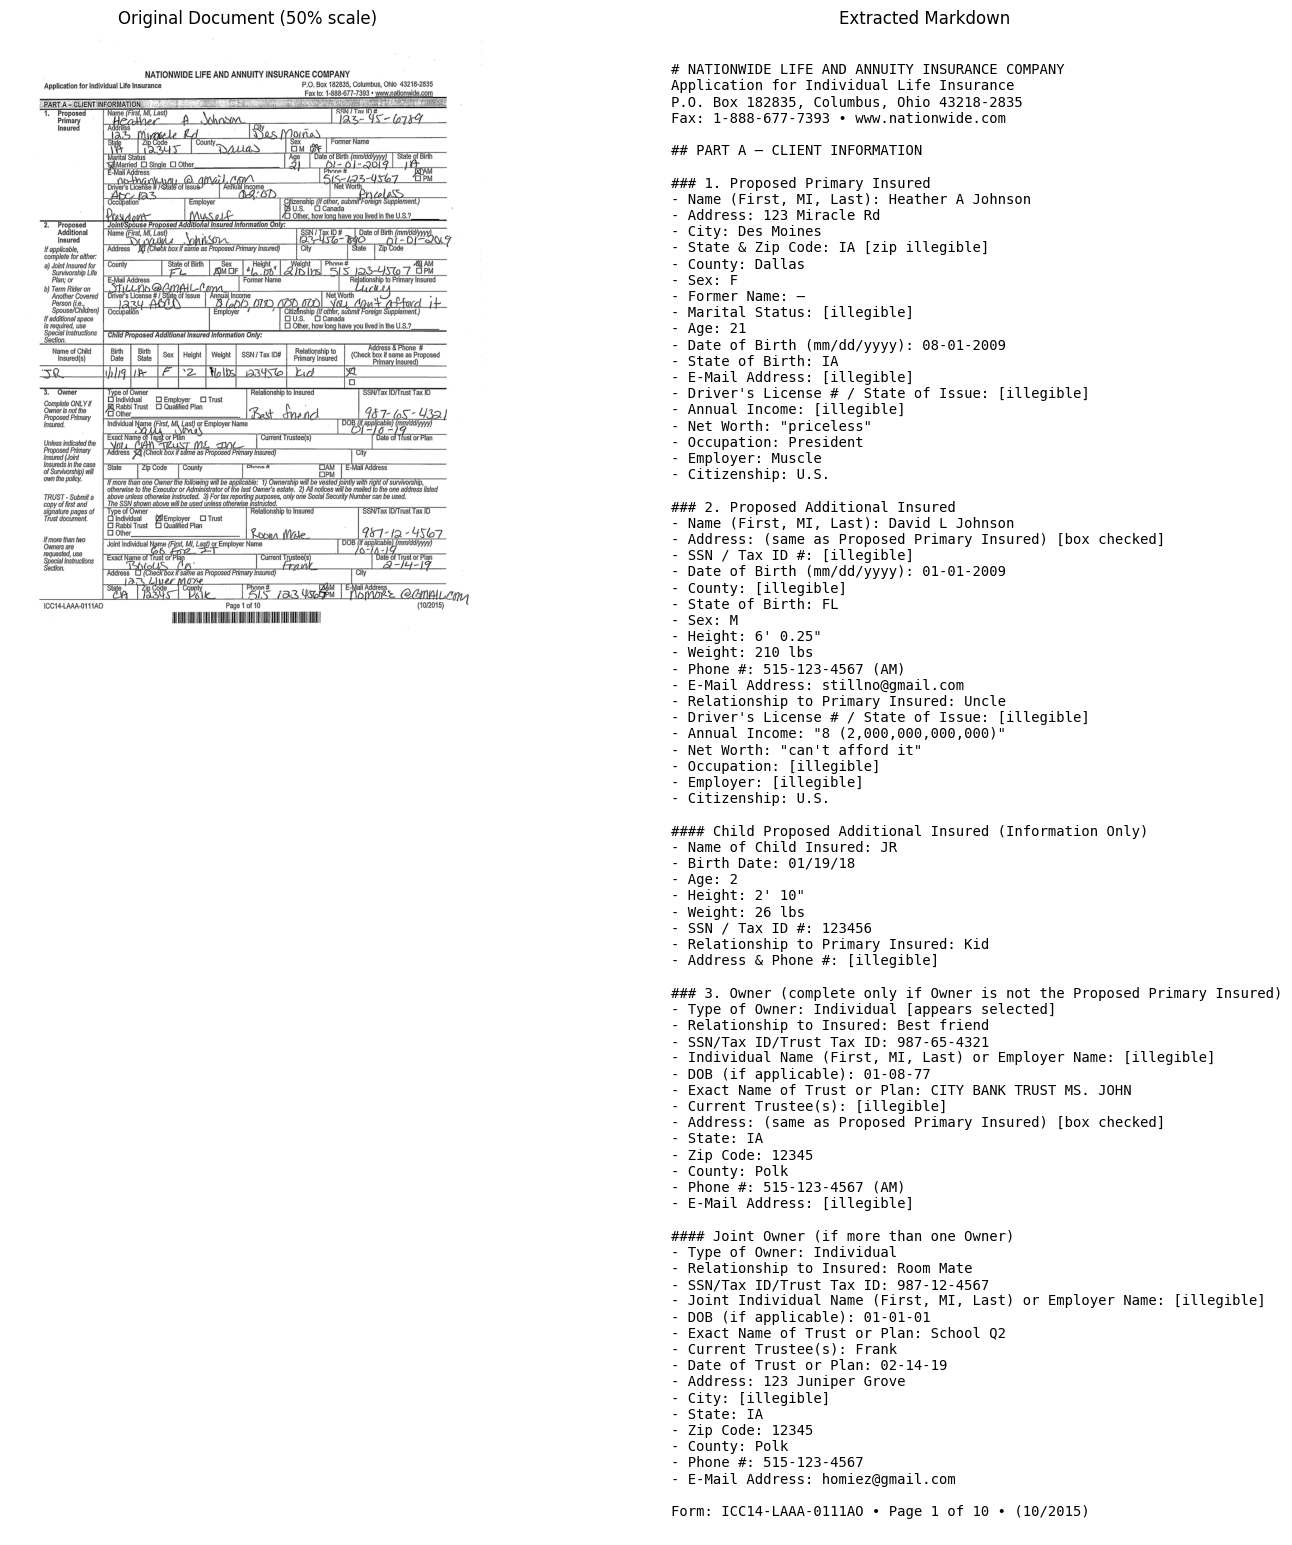

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

original_image = Image.open(sample_file_path)
width, height = original_image.size
resized_image = original_image.resize((max(1, width // 2), max(1, height // 2)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(resized_image)
ax1.set_title("Original Document (50% scale)")
ax1.axis('off')

ax2.text(0.05, 0.95, markdown_text, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace', wrap=True)
ax2.set_title("Extracted Markdown")
ax2.axis('off')

plt.tight_layout()
plt.show()


## Tips
- Adjust `fields_to_extract` for your use case.
- Keep `temperature` low for deterministic JSON outputs.
- For PDFs, rasterize pages to images before sending.
- Ensure your deployment is vision-capable (e.g., GPT-4o, GPT-5).
